In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Q1) Write an RK4 integrator with prototype to take one step. Use $\frac{dy}{dx} = \frac{y}{1+x^2}$, from $x=-20$ to $x=20$, with $y(-20)=1$ using $200$ steps.

In [4]:
def rk4_step(fun,x,y,h):
    k1=fun(x,y)
    k2=fun(x+h/2,y+h*k1/2)
    k3=fun(x+h/2,y+h*k2/2)
    k4=fun(x+h,y+h*k3)
    dy=h*(k1+2*k2+2*k3+k4)/6
    return y+dy
    
def func(x,y):
    dydx=y/(1+x**2)
    return dydx

In [5]:
# Now define linspace and integrate for 200 steps

npt = 201
xx = np.linspace(-20, 20, npt)
h = (xx[1]-xx[0]) # step size
yy1 = np.zeros(npt)
y0 = 1 # initial condition
yy1[0] = y0

for i in range(npt-1): # iterate over all points after initial point, integrating
    yy1[i+1] = rk4_step(func,xx[i],yy1[i],h)

integral = yy1[-1] - yy1[0]
print('Regular RK4 integration yields: ', integral)

Regular RK4 integration yields:  19.940049188005364


In [6]:
# We can compare with the analytic solution of y(x) = c0exp(arctan(x)), 
# first we need to find c0

c0 = 1/np.exp(np.arctan(-20))
true_ans = c0*(np.exp(np.arctan(20)) - np.exp(np.arctan(-20)))
print('The analytic answer is: ', true_ans)

The analytic answer is:  19.940306913620812


# Now write another stepper that takes a step of length $h$, compares that to two steps of $h/2$, and uses them to cancel out the leading-order error term from RK4. How many function evaluations per step does this one use? Use this modified stepper to carry out the same ODE solution using the $\textit{same number of function evaluations}$ as the original. Which is more accurate?

In [7]:
def rk4_stepd(fun,x,y,h):
    # one full step
    fstep = rk4_step(fun, x, y, h)
    # two half-steps
    hstep1 = rk4_step(fun, x, y, h/2)
    hstep2 = rk4_step(fun, x+h/2, hstep1, h/2)
    print(hstep1, hstep2)
    return hstep2 +(hstep2-fstep)/15

In [8]:
def rk4_stepd(fun,x,y,h):
    # one full step
    k1=fun(x,y)
    k2=fun(x+h/2,y+h*k1/2)
    k3=fun(x+h/2,y+h*k2/2)
    k4=fun(x+h,y+h*k3)
    dy=h*(k1+2*k2+2*k3+k4)/6
    fstep=y+dy
    # two half-steps
    k2_1=fun(x+h/4,y+h*k1/4)
    k3_1=fun(x+h/4,y+h*k2_1/4)
    k4_1=fun(x+h/2,y+h*k3_1/2)
    dy_1=h*(k1+2*k2_1+2*k3_1+k4_1)/12
    hstep1=y+dy_1
    k1_2=fun(x+h/2, hstep1)
    k2_2=fun(x+3*h/4,hstep1+h*k1_2/4)
    k3_2=fun(x+3*h/4,hstep1+h*k2_2/4)
    k4_2=fun(x+h,hstep1+h*k3_2/2)
    dy_2=h*(k1_2+2*k2_2+2*k3_2+k4_2)/12
    hstep2=hstep1+dy_2
    return hstep2 +(hstep2-fstep)/15

In [9]:
npt = 201
xx = np.linspace(-20, 20, npt)
h = (xx[1]-xx[0]) # step size
yy2 = np.zeros(npt)
y0 = 1 # initial condition
yy2[0] = y0

for i in range(npt-1): # iterate over all points after initial point, integrating
    yy2[i+1] = rk4_stepd(func,xx[i],yy2[i],h)
    
integral_adapt = yy2[-1]-yy2[0]
print('Adaptive RK4 integration yields: ', integral_adapt)

Adaptive RK4 integration yields:  19.940307381100723


# Q2a) Write a program to solve for the decay of products of U238 (see slides). You can use the ODE solver from scipy, but need to set up problem properly. Include all decay products in the chain. Assume you start from a sample of pure U238. What solver would you use for this problem?

The $i^{th}$ nuclide's decay may be written as $\frac{dN_i}{dt} = \lambda_{i-1} N_{i-1} - \lambda_i N_i$, whilst the $0^{th}$ is $\frac{dN_0}{dt} = -\lambda_0 N_0$, and the last decay is simply $\frac{dN_{n-1}}{dt} = \lambda_{n-1} N_{n-1}$, given the first decay has no preceding nuclide and the last decay results in a stable nuclide. Taking $\lambda = \tau^{-1}$ for $\tau$ being the the mean lifetime of the nuclide we can compute its half-life as $t_{1/2} = \frac{\text{ln}(2)}{\lambda}$, and hence replace $\lambda_i$ with $\frac{\text{ln}(2)}{t_{1/2, i}}$ in the previously stated equations.

In [10]:
from scipy import integrate

In [11]:
# Make list with half-lives of different nuclides (in years)

half_lives = [4.468e9, 24.10/365, 6.70/ 24 /365, 245500, 75380, 1600, 38235/365, 3.10/60/24/365, 26.8/60/24/365,
             19.9/60/24/365, 164.3*1e-6 /60/60/24/365, 22.3, 5015, 138.376/365]

# Define function for the decay of a multiple nuclides

def decay(t, N, half_life=half_lives):

    dNdt = np.zeros(len(half_life)+1)
    A = np.log(2) # constant for half-life
    
    for i in range(len(dNdt)): # iterate through nuclide decays
        if i == 0:
            dNdt[0] = -A*N[0]/half_life[0] # first decay
        elif i == (len(half_life)):
            dNdt[-1] = A*N[-2]/half_life[-2] # last decay
        else:
            dNdt[i] = A*(N[i-1]/half_life[i-1] - N[i]/half_life[i])
    return dNdt

Now that we have defined our decay process and calculated the half-lives from the slides in class in terms of Earth-years, we can numerically integrate using scipy integration. Given the question states we start with pure U238, we set this initial value to 1 and leave all other nuclides as 0. To choose the type of solver, we consider what we saw in class where the RK4 algorithm was very slow and required several orders of magnitude larger evaluations compared to the Radau method. Therefore, we will use the Radau method here, and integrate over a time interval of comparable magnitude to the half-life of U238, as if we set this interval to be several orders of magnitude smaller, there will be no evolution of the system as the first nuclide in the chain will not have decayed. In this instance, we will conservatively choose $10^{10}$, which is approximately two half-lives of U238.

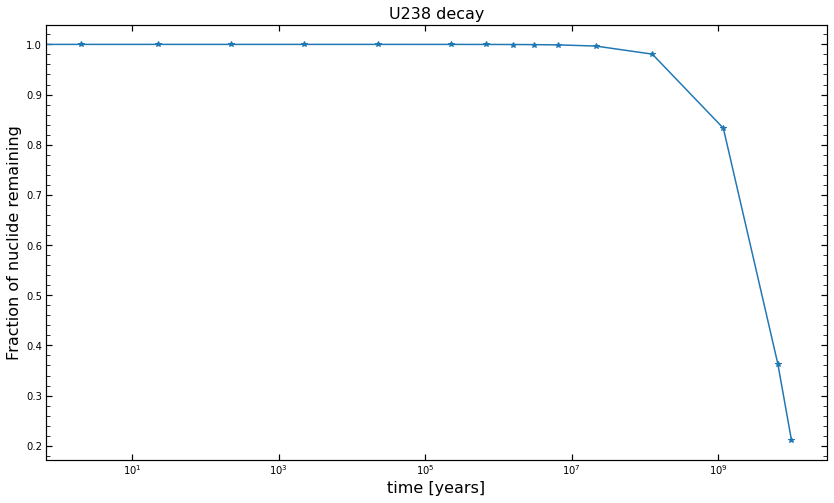

In [12]:
# Define the starting point, where we have pure U238, set to 1 for simplicity

zeros = np.zeros(len(half_lives)+1)
zeros[0] = 1
N0 = zeros
t0,t1 = 0, 1e10 # time interval bounds
#teval = np.linspace(t0, t1, 100) # times to store solution at

ans_stiff = integrate.solve_ivp(decay,[t0, t1], N0, method='Radau')# t_eval=teval)
fig, ax = plt.subplots(figsize=[14, 8])
ax.plot(ans_stiff.t, ans_stiff.y[0,:], '*-')
ax.set_ylabel('Fraction of nuclide remaining', fontsize=16)
ax.set_xlabel('time [years]', fontsize=16)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('U238 decay', fontsize=16);

# Q2b) Plot the ratio of Pb206 to U238 as a function of time over a region where it's interesting. Does this make sense analytically? (All half-lives are short compared to U238, so you can approximate the U238 decaying instantly to lead). Now plot the ratio of Thorium 230 to U234 over a region where that is interesting. 

Pb206 is the last element in the chain, and therefore we can compute the ratio of Pb206 to U238 by dividing the last element by the first element as a function of time (which we have already computed above).

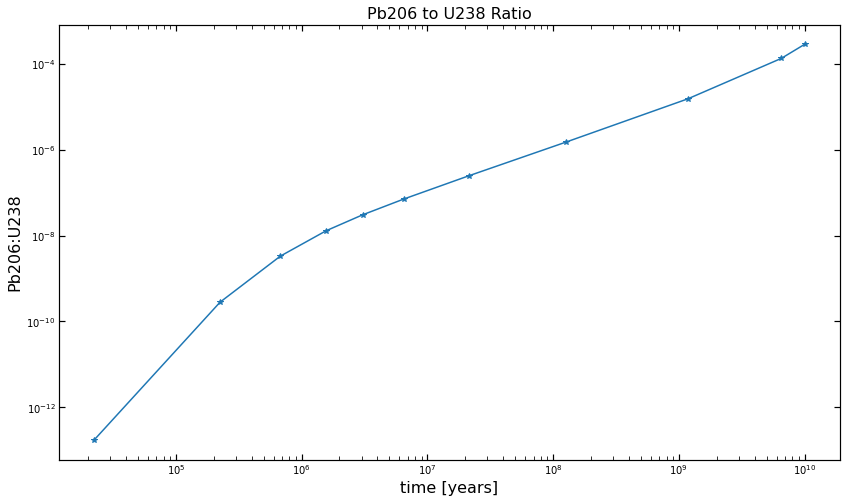

In [13]:
Pb206 = ans_stiff.y[-1,:]
U238 = ans_stiff.y[0,:]

fig, ax = plt.subplots(figsize=[14, 8])
ax.plot(ans_stiff.t[5:], (Pb206/U238)[5:], '*-')
ax.set_ylabel('Pb206:U238', fontsize=16)
ax.set_xlabel('time [years]', fontsize=16)
ax.set_title('Pb206 to U238 Ratio', fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log');

We see the progressive increase in the ratio with time as more Pb206 is formed and more U238 decays. Over an interval of $\approx 1$ billion years, the ratio jumps from $\approx 10^{-12}$ to $\approx 10^{-4}$.

<ipython-input-14-901844d9f150>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(ans_stiff.t[:8], (Th230/U234)[:8], '*-')


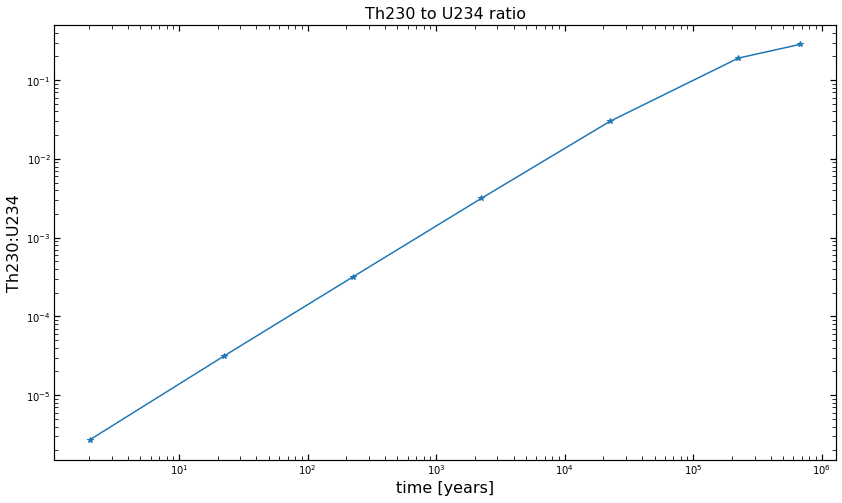

In [14]:
Th230 = ans_stiff.y[4,:]
U234 = ans_stiff.y[3,:]

fig, ax = plt.subplots(figsize=[14, 8])
ax.plot(ans_stiff.t[:8], (Th230/U234)[:8], '*-')
ax.set_ylabel('Th230:U234', fontsize=16)
ax.set_xlabel('time [years]', fontsize=16)
ax.set_title('Th230 to U234 ratio', fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log');

In this instance, the ratio evolves over a much smaller timescale and earlier on given the two nuclides are further up in the chain than Pb206. Over a period of $\approx 10^5$ years, the ratio increases from $10^{-6} \rightarrow 10^{-1}$.

# Q3a) Look at file dish_zenith.txt, containing data for prototype telescope dish. The end result is that dish_zenith.txt contains the (x,y,z) positions in mm of a few hundred targets placed on the dish. The ideal telescope dish should be a rotationally symmetric paraboloid. We will try to measure the shape of the paraboloid, and see how well we did. For the dish pointing in the z-direction, we have a rotationally symmetric paraboloid, $z - z_0 = a((x-x_0)^2 + (y-y_0)^2)$ where we need to solve for $x_0, y_0, x_0, a$. Show that we can pick a set of new parameters that make the problem linear. What are these new parameters and how to they relate to the old ones?

We can pick a set of new parameters by expanding out the formula for the parabola and rearranging as such,
\begin{equation}
z = a(x^2+y^2) - 2a x_0 x - 2a y_0 y + (z_0 + ax_0^2 + ay_0^2) \\
\implies z = A(x^2 + y^2) + Cx + Dy + E \,\,\,\, \text{for} \,\,\,\, A = a, C = -2ax_0, D = -2ay_0, E = z_0+ax_0^2+ay_0^2.
\end{equation}

Therefore, given we now have a linear equation we can rewrite our paraboloid equation with these new parameters, which are related to the old parameters $(x_0, y_0, z_0, a)$ by the following set of equations;

\begin{equation}
x_0 = \frac{C}{-2A}, \,\, y_0 = \frac{D}{-2A}, \,\, z_0 = E - \frac{C}{4A} - \frac{D}{4A}, \,\, a = A.
\end{equation}

# Q3b) Carry out the fit, what are the best-fit parameters?

In [15]:
# Load the new data
data=np.loadtxt('dish_zenith.txt')
xdat, ydat, zdat = data.T

As we saw in class, we can find the best-fitting model by minimizing chi-square, defined as $\chi^2 = (d-A(m))^T N^{-1} (d-A(m))$, where $d$ is our data (in this case $z$) and $A(m)$ is our model that is dependent on the parameters $m$ (in this case we also have $x, y$ dependence). We take the result we derived in class for a linear least squares fit, where the best fit parameters $m$ as given by, 

\begin{equation}
m = (A^T N^{-1} A)^{-1} A^T N^{-1} d
\end{equation}

where for the present we have assumed $N$ is the identity matrix. We also saw in class that the parameter covariance matrix is given by $(A^T N^{-1} A)^{-1}$, so we may estimate the errors on our final parameters as well.

In [16]:
# We define A to be an nxm matrix (for n data points and m parameters)

def best_fit(x, y, z, num_params):
    
    A = np.zeros((len(x), num_params))
    d = z
    
    for i in range(len(x)): # iterate through data points, populate A
        A[i,0] = (x[i]**2 + y[i]**2)
        A[i,1] = x[i]
        A[i,2] = y[i]
        A[i,3] = 1 # just a constant
    
    # Now given we have A and d calculate best fit params --> m
    lhs_inv = np.linalg.inv(A.T@A)
    m = lhs_inv@A.T@d
    res = d - A@m
    cov = lhs_inv
    A,C,D,E = m
    
    # m is of the form [A, C, D, E] so we use the above formulas to get [x0,y0,z0,a]
    x0,y0,z0,a = C/(-2*A), D/(-2*A), (E-C/(4*A)-D/(4*A)), A
    
    return m, [x0,y0,z0,a], res, cov

In [17]:
# Now we can get our best fit parameters for (x0, y0, z0, a)
linearized_bfit_params, orig_bfit_params, res, cov = best_fit(xdat,ydat,zdat, 4)

print('Linearized Best fit parameters; A = ' + repr(linearized_bfit_params[0]) +', C = ' + repr(linearized_bfit_params[1]) +
      ', D = ' + repr(linearized_bfit_params[2]) + ', E = ' + repr(linearized_bfit_params[3]))
print('Original Best fit parameters; x0 = ' + repr(orig_bfit_params[0]) +', y0 = ' + repr(orig_bfit_params[1]) +
      ', z0 = ' + repr(orig_bfit_params[2]) + ', a = ' + repr(orig_bfit_params[3]))

Linearized Best fit parameters; A = 0.00016670445477401355, C = 0.0004535990279795366, D = -0.01941155885263565, E = -1512.3118166739077
Original Best fit parameters; x0 = -1.3604886221980108, y0 = 58.22147608157856, z0 = -1483.8813229442173, a = 0.00016670445477401355


# Q3c) Estimate noise in the data, and from that, uncertainty in $a$. Our target focal length was 1.5 m. What did we actually get, and what is the error bar? When calculating the error bar for the focal length, feel free to approximate using a first-order Taylor expansion.

We know from class that to get the noise from a large number of data points (which we have here), we can take the noise to be the square root of the variance of the residuals (and their magnitudes are relatively constant). Therefore, we can compute the noise from the variance f the residuals as;

\begin{equation}
\sqrt{\sigma^2} = \sqrt{\frac{1}{n} \sum_{i=1}^n (d_i-A(m_{BF}))^2} \,\,\,\, \text{for} \,\,\,\, m_{BF} = \text{best fit parameters}.
\end{equation}

From here, we can compute the uncertainty in our best fit parameters as $(A^T N^{-1} A)^{-1}$, where $N = \sigma$ from above. We have already returned/computed the covariance matrix from for the case where $N=I_{nxn}$, and therefore simply dividing by our new $N$ (given $N$ is diagonal and constant) will give us the new parameter covariance matrix. From here, we can obtain the uncertainty in $a$ by taking the square root of the first diagonal entry (given our construction of the $A(m)$ matrix and the coefficient $A = a$). 

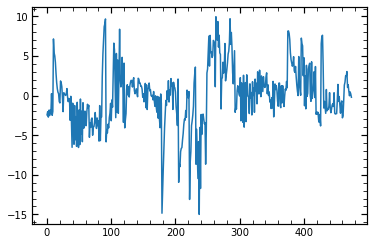

In [18]:
plt.plot(res)

In [19]:
# Now compute the noise in the data given the residuals were calculated in the previous function
n = len(zdat)
N = np.sqrt( 1/n *np.sum(res**2) ) # rms of residuals

# Uncertainty on a
a_err = np.sqrt(np.diag(cov/N))[0]
print('The uncertainty on a is ', np.round(a_err, 10))

The uncertainty on a is  8.8e-09


The focal length may be written in terms of $a$ as, $f = \frac{1}{4a}$, where we have calculated $a$ from our linear least squares fit above. We can propagate the uncertainty on $a$ through this formula for $f$ as,

\begin{equation}
\delta f = \sqrt{(\frac{df}{da} \delta a)^2}, \,\,\,\, \text{where} \,\,\,\, \frac{df}{da} = -\frac{1}{4a^2} \\
\implies \delta f = \sqrt{\frac{(\delta a)^2}{16a^4}} = \frac{\delta a}{4a^2}.
\end{equation}

In [31]:
# Compute uncertainty on f

a = linearized_bfit_params[0]
f = 1/(4*a)
f_err = a_err/(4*a**2)

print('The focal length is ' + repr(np.round(f/1000, 5)) + ' +/- ' + repr(np.round(f_err/1000, 5)) + ' m.')

The focal length is 1.49966 +/- 8e-05 m
